# Homework 3

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Yumeng Zhang (12372205)
* ymzhang@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology`,
- the market data file `market_prices_eod` and
- the corporate bonds call schedule file `call_schedules`.


I referred to Intro_QuantLib_v2.ipynb.

# Problem 1: More details on callable bonds: "workout-date" and "yield-to-worst" calculations

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline

## a. Load and explore the call schedules dataframe

Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.

For each bond in the dataframe, compute the total number of outstanding calls.

In [2]:
df_call_schedule = pd.read_excel('data/call_schedules.xlsx', sheet_name='Sheet1')
df_call_schedule

,isin,figi,call_date,call_price
0,US254687CZ75,BBG00QNKJ092,2024-06-15,100
1,US254687DD54,BBG00QNKPCL5,2025-07-15,100
2,US254687DK97,BBG00QNKGJP6,2026-08-15,100
3,US254687EX00,BBG00QNKKP22,2045-04-15,100
4,US254687FB70,BBG00QNKKP68,2046-05-15,100
...,...,...,...,...
110,US92346MHV63,BBG012F6PR25,2031-03-15,100
111,US92346MJS17,BBG0175X1628,2023-05-15,100
112,US92346MJZ59,BBG017QYK9Z0,2023-06-15,100
113,US92346MKG59,BBG0191HMXJ3,2023-08-15,100


In [3]:
df_call_schedule['call_date'] = pd.to_datetime(df_call_schedule['call_date'])

today = pd.Timestamp(dt.date.today())
df_outstanding_calls = df_call_schedule[df_call_schedule['call_date'] > today].groupby(['isin', 'figi'])\
    .size().reset_index(name='num_call_dates')

df_outstanding_calls

,isin,figi,num_call_dates
0,US254687CZ75,BBG00QNKJ092,1
1,US254687DD54,BBG00QNKPCL5,1
2,US254687DK97,BBG00QNKGJP6,1
3,US254687EX00,BBG00QNKKP22,1
4,US254687FB70,BBG00QNKKP68,1
...,...,...,...
95,US92346MHV63,BBG012F6PR25,16
96,US92346MJS17,BBG0175X1628,1
97,US92346MJZ59,BBG017QYK9Z0,1
98,US92346MKG59,BBG0191HMXJ3,1


## b. Load symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.

Load the `corp_symbology` Excel file into a dataframe and keep only the fixed-rate callable bonds from 1a.

Extend the dataframe with the column computed in 1a:

| num_call_dates |
|----------|

In [4]:
df_corp_symbology = pd.read_excel('data/corp_symbology.xlsx', sheet_name='Sheet1')

In [5]:
df_corp_symbology = pd.merge(df_corp_symbology, df_outstanding_calls, on=['figi', 'isin'], how='left')
df_corp_symbology = df_corp_symbology.dropna().reset_index(drop = True)
df_corp_symbology['num_call_dates'] = df_corp_symbology['num_call_dates'].astype(int)
df_corp_symbology

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency,num_call_dates
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD,1
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD,1
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD,1
3,DIS,Corp,BBG00QNKKP22,US254687EX00,DIS4920157,US912810TQ13,DIS 4.95 10/15/45,WALT DISNEY COMPANY/THE,GLOBAL,4.950,...,2,2019-11-22,2020-04-15,2019-10-15,2045-10-15,CALLABLE,Sr Unsecured,US,USD,1
4,DIS,Corp,BBG00QNKKP68,US254687FB70,DIS4907442,US912810TQ13,DIS 4 3/4 11/15/46,WALT DISNEY COMPANY/THE,GLOBAL,4.750,...,2,2019-11-22,2020-05-15,2019-11-15,2046-11-15,CALLABLE,Sr Unsecured,US,USD,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,VZ,Corp,BBG012F6PR25,US92346MHV63,VZ5256196,US912810TL26,VZ 3.05 09/15/51,VERIZON COMMUNICATIONS,DOMESTIC MTN,3.050,...,2,2021-09-16,2022-03-15,2021-09-16,2051-09-15,CALLABLE,Sr Unsecured,US,USD,16
94,VZ,Corp,BBG0175X1628,US92346MJS17,VZ5410330,US912810TL26,VZ 4.55 05/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.550,...,2,2022-05-12,2022-11-15,2022-05-12,2052-05-15,CALLABLE,Sr Unsecured,US,USD,1
95,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,US912810TL26,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.650,...,2,2022-06-03,2022-12-15,2022-06-03,2052-06-15,CALLABLE,Sr Unsecured,US,USD,1
96,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,US912810TL26,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.600,...,2,2022-08-11,2023-02-15,2022-08-11,2052-08-15,CALLABLE,Sr Unsecured,US,USD,1


## c. Add a function to compute "workout date" and "yield-to-worst" for a fixed-rate callable bond

Quick recap: given the current market price, the issuer is expected to call a callable bond on the call date corresponding to lowest bond yield "to call date" (which is the best possible scenario from the point of view of the issuer exercising the call option). The lowest yield for a call date is called the "yield-to-worst" and the corresponding call date (on which the issuer is expected to call the bond) is called the "workout date". Keep in mind that the "workout date" could be at the bond maturity date, in which case "yield-to-worst" = "yield-to-maturity".

To do: For a callable bond, with known symbology (reference data) and call schedules dataframes, create a function that takes the clean market price as an input and returns "workout date" and "yield-to-worst".

Internally, for each call date, create a separate "call scenario bond" object using the function create_bond_from_symbology() from Homework 2, and then compute the corresponding "call scenario yield" for the "call scenario bond" (using the bond clean market price).


In [6]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])    
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first']) 
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    # all values in cpn_freq in df_symbology are 2.0 (Yumeng)
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
    # Create day_count from details['dcc']
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    # For US Corporates use ql.Thirty360(ql.Thirty360.USA)

    # day_count = ql.Thirty360(ql.Thirty360.USA)   # update code depending on dcc !!!

    if details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    elif details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])    # use date helper function and update code !!!
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond

In [7]:
def calc_yield_to_worst(
            details: dict,
            pc_schedule: pd.DataFrame,
            bond_clean_price: float,
            calc_date: ql.Date):
    '''Computes yield-to-worst and workout date for fixed rate callable bonds.
    '''    
    
    # iterate over the call schdeule entries and compute the scenario yields
    # Identify the smalles yield as "yield-to-worst"
    
    # update code!!!
    workout_date = ql.Date()    # compute workout date !!!
    yield_to_worst = 0.05       # compute yield to worst !!!  

    call_date_list = list(df_call_schedule['call_date'])
    yield_list = []

    for date in call_date_list:

        details['maturity'] = date
        
        bond_object = create_bond_from_symbology(details)

        settle_date = bond_object.settlementDate(calc_date)
        day_count = bond_object.dayCounter()

        compounding = ql.Compounded
        coupon_freq = ql.Semiannual
        
        bond_yield = bond_object.bondYield(bond_clean_price, day_count, compounding, coupon_freq, settle_date)*100
        yield_list.append(bond_yield)

    yield_to_worst = min(yield_list)
    yield_to_worst_index = yield_list.index(yield_to_worst)

    # workout_date = get_ql_date(call_date_list[yield_to_worst_index])
    workout_date = call_date_list[yield_to_worst_index]


    return workout_date, yield_to_worst

## d. Compute "workout dates" and "yields-to-worst" for all fixed-rate callable bonds

Load the `market_prices_eod` Excel file into a dataframe, which contains marktet quotes as of 2023-04-14.

For each fixed-rate callable bond in the symbology dataframe from 1b (using calc_date = '2023-04-14' and clean market prices):
- 1. Compute the yield to maturity 

- 2. Use the function from 1c to compute "workout date" and "yield-to-worst".

Extend the symbology dataframe with the following columns:


| clean_price |  yield_to_maturity | workout_date | yield_to_worst |
|----------|-------------|-------|-------------|



In [8]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

In [9]:
df_market = pd.read_excel('data/market_prices_eod.xlsx', sheet_name='Sheet1')

df_corp_symbology = pd.merge(df_corp_symbology, df_market[['isin','figi','bid','ask','mid_clean','mid_dirty','bid_yield','ask_yield']],\
    on=['figi', 'isin'], how='left')

In [10]:
def compute_ytm(df_corp_symbology):

    df_corp_symbology['clean_price'] = 0.0
    df_corp_symbology['yield_to_maturity'] = 0.0

    for index, row in df_corp_symbology.iterrows():

        bond_object = create_bond_from_symbology(row)

        settle_date = bond_object.settlementDate(calc_date)
        day_count = bond_object.dayCounter()

        compounding = ql.Compounded
        coupon_freq = ql.Semiannual
        
        bond_analytical_yield = bond_object.bondYield(row['mid_clean'], day_count, compounding, coupon_freq, settle_date)*100

        df_corp_symbology['clean_price'][index] = row['mid_clean']
        df_corp_symbology['yield_to_maturity'][index] = bond_analytical_yield

    return df_corp_symbology

In [11]:
def compute_ytw(df_corp_symbology, df_call_schedule, calc_date):

    df_corp_symbology['workout_date'] = np.NaN
    df_corp_symbology['yield_to_worst'] = 0.0

    for i in range(len(df_corp_symbology)):

        details = df_corp_symbology.iloc[i].to_dict()
        workout_date, yield_to_worst = calc_yield_to_worst(details, df_call_schedule, details['mid_clean'], calc_date)

        df_corp_symbology['workout_date'][i] = workout_date
        df_corp_symbology['yield_to_worst'][i] = yield_to_worst

    return df_corp_symbology

In [12]:
df_corp_symbology = compute_ytm(df_corp_symbology)
df_corp_symbology = compute_ytw(df_corp_symbology, df_call_schedule, calc_date)
df_corp_symbology[['clean_price','yield_to_maturity','workout_date','yield_to_worst']]

,clean_price,yield_to_maturity,workout_date,yield_to_worst
0,98.763,4.614951,2060-09-22 00:00:00,3.761761
1,98.637,4.282420,2060-09-22 00:00:00,3.768126
2,97.230,4.217140,2060-09-25 00:00:00,3.508410
3,98.660,5.050324,2060-09-22 00:00:00,5.029609
4,96.513,5.003280,2060-09-22 00:00:00,4.955520
...,...,...,...,...
93,62.167,5.775661,2060-09-25 00:00:00,5.420861
94,86.643,5.472804,2060-09-25 00:00:00,5.382817
95,87.994,5.478803,2060-09-25 00:00:00,5.400224
96,87.750,5.440116,2060-09-25 00:00:00,5.361716


# Problem 2: Perpetual bonds
## a. Price a fixed rate perpetual bond
We are interested in a fixed rate perpetual bond (infinite maturity) on a face notional of $100 and semi-annual coupon c.

Assuming that the bond has a (continuously componded) yield of y, what is the fair value price of the bond?

For simplicity, you can assume T+0 settlement and zero accrued.

$fair\,value\, price = \frac{coupon\,cash\,flow}{discount\,rate}  = \frac{c}{y}$

## b. Perpetual bonds priced "at par"
For which yield y does the bond trade "at par", i.e. fair value price = $100?

$\frac{c}{y} = 100$

$yield = \frac{c}{100}$

## c. Duration and DV01 for a fixed rate perpetual bond
Compute Duration and DV01 of the perpetual bond.

$Duration = \frac{1+y}{y}$

$DV01 = Duration \times \frac{100}{1+y} \times \frac{1}{100} = \frac{1}{y}$

## d. Convexity of a fixed rate perpetual bond
Compute the convexity of the perpetual bond.

$Convexity = \frac{2}{(1+y)^2}$

# Problem 3: US SOFR swap curve calibration as of 2023-04-28
### Follow Section "11. SOFR OIS swap rates and SOFR discount curve calibration + validation" in the QuantLib Intro notebook !!!

## a. Load and explore US SOFR swaps symbology and market data

Load the `sofr_swap_symbology` Excel file into a dataframe. Print all swap tenors available.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.

In [13]:
df_sofr_symbology = pd.read_excel('data/sofr_swaps_symbology.xlsx', sheet_name='Sheet1')
df_sofr_symbology

,figi,ticker,class,bbg,name,term,type,dcc,exchange,country,currency,status
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
4,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV
5,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV
6,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
7,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV


In [14]:
print(list(df_sofr_symbology['term']))

[1, 2, 3, 5, 7, 10, 20, 30]


In [15]:
df_sofr_market = pd.read_excel('data/sofr_swaps_market_data_eod.xlsx', sheet_name='Sheet1')
df_sofr_market = df_sofr_market.rename(columns={'symbol': 'figi'})
df_sofr_market

,date,figi,mid_rate
0,2023-01-03,BBG00KFWPKF0,3.30670
1,2023-01-03,BBG00KFWPKH8,3.06370
2,2023-01-03,BBG00KFWPKB4,3.39850
3,2023-01-03,BBG00KFWPK79,3.48140
4,2023-01-03,BBG00KFWPK51,3.62240
...,...,...,...
643,2023-04-28,BBG00KFWPK79,3.18275
644,2023-04-28,BBG00KFWPK51,3.28700
645,2023-04-28,BBG00KFWPJJ9,4.79000
646,2023-04-28,BBG00KFWPJX3,4.01500


In [16]:
date_list = list(set(list(df_sofr_market['date'])))
print(date_list)

[Timestamp('2023-03-08 00:00:00'), Timestamp('2023-03-20 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp('2023-02-22 00:00:00'), Timestamp('2023-03-14 00:00:00'), Timestamp('2023-04-06 00:00:00'), Timestamp('2023-03-02 00:00:00'), Timestamp('2023-01-04 00:00:00'), Timestamp('2023-03-16 00:00:00'), Timestamp('2023-01-25 00:00:00'), Timestamp('2023-02-27 00:00:00'), Timestamp('2023-04-05 00:00:00'), Timestamp('2023-03-01 00:00:00'), Timestamp('2023-03-27 00:00:00'), Timestamp('2023-01-05 00:00:00'), Timestamp('2023-01-30 00:00:00'), Timestamp('2023-01-24 00:00:00'), Timestamp('2023-01-03 00:00:00'), Timestamp('2023-01-20 00:00:00'), Timestamp('2023-02-07 00:00:00'), Timestamp('2023-01-27 00:00:00'), Timestamp('2023-03-24 00:00:00'), Timestamp('2023-01-18 00:00:00'), Timestamp('2023-02-03 00:00:00'), Timestamp('2023-04-17 00:00:00'), Timestamp('2023-01-12 00:00:00'), Timestamp('2023-04-03 00:00:00'), Timestamp('2023-04-04 00:00:00'), Timestamp('2023-01-19 00:00:00'), Timestamp('20

In [17]:
def plot_SOFR_rates(df_sofr_market, df_sofr_symbology):

    df_sofr_market = pd.merge(df_sofr_market, df_sofr_symbology[['figi','term']],on=['figi'], how='left')

    unique_terms = df_sofr_market['term'].unique()
    plt.figure(figsize=(20,8))

    for term in unique_terms:
        df_filtered = df_sofr_market[df_sofr_market['term'] == term]
        plt.plot(df_filtered['date'], df_filtered['mid_rate'], label=f'{term} Y')

    plt.xlabel('Date')
    plt.ylabel('Mid Rate')
    plt.title('Historial Time Series of SOFR Rates for different tenors')

    plt.legend()
    plt.grid(True)

    plt.show()

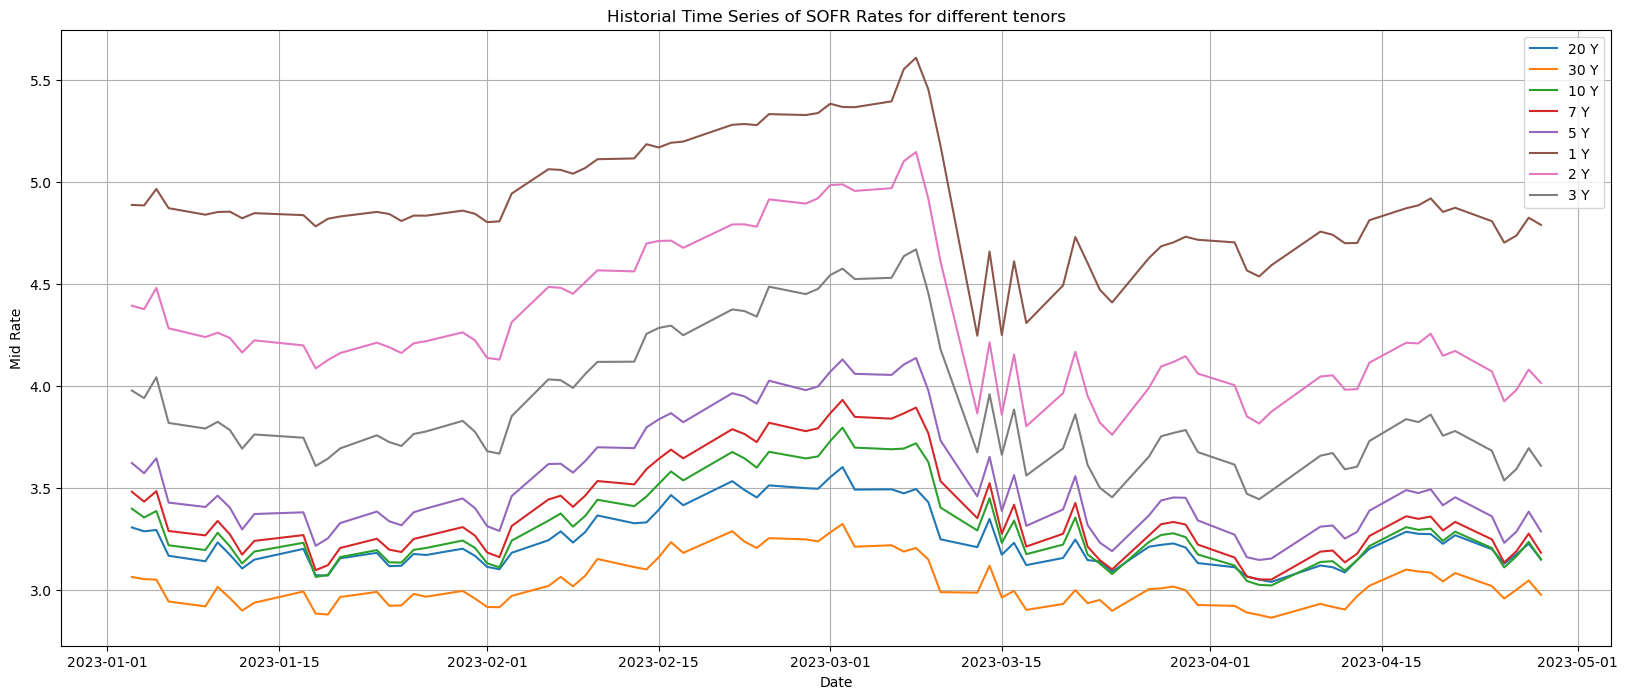

In [18]:
plot_SOFR_rates(df_sofr_market, df_sofr_symbology)

## b. Calibrate the US SOFR yield curve (via bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from SOFR swaps. 

Prepare a joint symbology & market dataframe quotes as of 2023-04-28. 

Calibrate the SOFR discount factor curve as of 2023-04-28.

Follow section 11b.

In [19]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [20]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [21]:
df_sofr = pd.merge(df_sofr_market, df_sofr_symbology,on=['figi'], how='left')
df_sofr = df_sofr[df_sofr['date'] == pd.to_datetime('2023-04-28')].reset_index(drop=True)
df_sofr = df_sofr.rename(columns={'term': 'tenor'})

In [22]:
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, df_sofr, "mid_rate")

In [23]:
df_sofr_yield_curve_simple = get_yield_curve_details_df(sofr_yield_curve)          
df_sofr_yield_curve_simple

,Date,YearFrac,DiscountFactor,ZeroRate
0,2023-04-18,0.000,1.000,4.788
1,2024-04-18,1.017,0.954,4.788
2,2025-04-21,2.039,0.923,3.998
3,2026-04-20,3.050,0.898,3.584
4,2028-04-18,5.075,0.850,3.255
5,2030-04-18,7.103,0.802,3.152
6,2033-04-18,10.147,0.732,3.123
7,2043-04-20,20.297,0.534,3.139
8,2053-04-18,30.439,0.419,2.899


In [24]:
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]
df_sofr_yield_curve_details = get_yield_curve_details_df(sofr_yield_curve, grid_dates) 
df_sofr_yield_curve_details

,Date,YearFrac,DiscountFactor,ZeroRate
0,2023-04-18,0.000,1.000,4.788
1,2025-04-18,2.031,0.923,4.004
2,2027-04-18,4.058,0.872,3.420
3,2029-04-18,6.089,0.825,3.204
4,2031-04-18,8.117,0.778,3.142
5,2033-04-18,10.147,0.732,3.123
6,2035-04-18,12.175,0.687,3.126
7,2037-04-18,14.206,0.646,3.129
8,2039-04-18,16.233,0.606,3.132
9,2041-04-18,18.264,0.569,3.136


## c. Display the calibrated SOFR discount curve dataframe

Follow section 11d to display the calibration details dataframe.

In [25]:
df_sofr_yield_curve_details

,Date,YearFrac,DiscountFactor,ZeroRate
0,2023-04-18,0.000,1.000,4.788
1,2025-04-18,2.031,0.923,4.004
2,2027-04-18,4.058,0.872,3.420
3,2029-04-18,6.089,0.825,3.204
4,2031-04-18,8.117,0.778,3.142
5,2033-04-18,10.147,0.732,3.123
6,2035-04-18,12.175,0.687,3.126
7,2037-04-18,14.206,0.646,3.129
8,2039-04-18,16.233,0.606,3.132
9,2041-04-18,18.264,0.569,3.136


In [26]:
def validate_sofr(df_sofr, sofr_yield_curve):

    df_sofr = df_sofr.sort_values(by='tenor').reset_index(drop = True)

    settle_days = 2
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)
    sofr_index = ql.Sofr(sofr_yield_curve_handle)

    print('SOFR Swap valuation: PVs should be close to zero!')

    for i in range(len(df_sofr)):

        SOFR_tenor = ql.Period(int(df_sofr['tenor'][i]), ql.Years)
        SOFR_rate = df_sofr['mid_rate'][i]
        start_date = calendar.advance(calc_date, settle_days, ql.Days)
        schedule = ql.MakeSchedule(start_date, calendar.advance(start_date, SOFR_tenor), ql.Period('1Y'), calendar=calendar)        
        oisSwap = ql.MakeOIS(SOFR_tenor, sofr_index, SOFR_rate/100, nominal=100)
        
        print('Swap PV for', SOFR_tenor, 'tenor /', SOFR_rate, 'coupon :', oisSwap.NPV())   

In [27]:
validate_sofr(df_sofr, sofr_yield_curve)

SOFR Swap valuation: PVs should be close to zero!
Swap PV for 1Y tenor / 4.79 coupon : 0.0
Swap PV for 2Y tenor / 4.015 coupon : 8.881784197001252e-15
Swap PV for 3Y tenor / 3.609 coupon : -1.3145040611561853e-13
Swap PV for 5Y tenor / 3.287 coupon : 1.0665957006494864e-10
Swap PV for 7Y tenor / 3.18275 coupon : -8.58015880567109e-11
Swap PV for 10Y tenor / 3.14875 coupon : -6.24069684818096e-11
Swap PV for 20Y tenor / 3.15105 coupon : 1.1368683772161603e-13
Swap PV for 30Y tenor / 2.97675 coupon : 2.1316282072803006e-14


## d. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves

Plot the SOFR zero rates and discount factor curves by maturity. Follow section 11c.

In [28]:
def plot_SOFR_zero_rate(df_sofr_yield_curve_details):

    plt = df_sofr_yield_curve_details.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates', figsize=(20,8))
    plt.set_ylabel('Zero Rate (%)')
    plt.set_xlabel('Date')

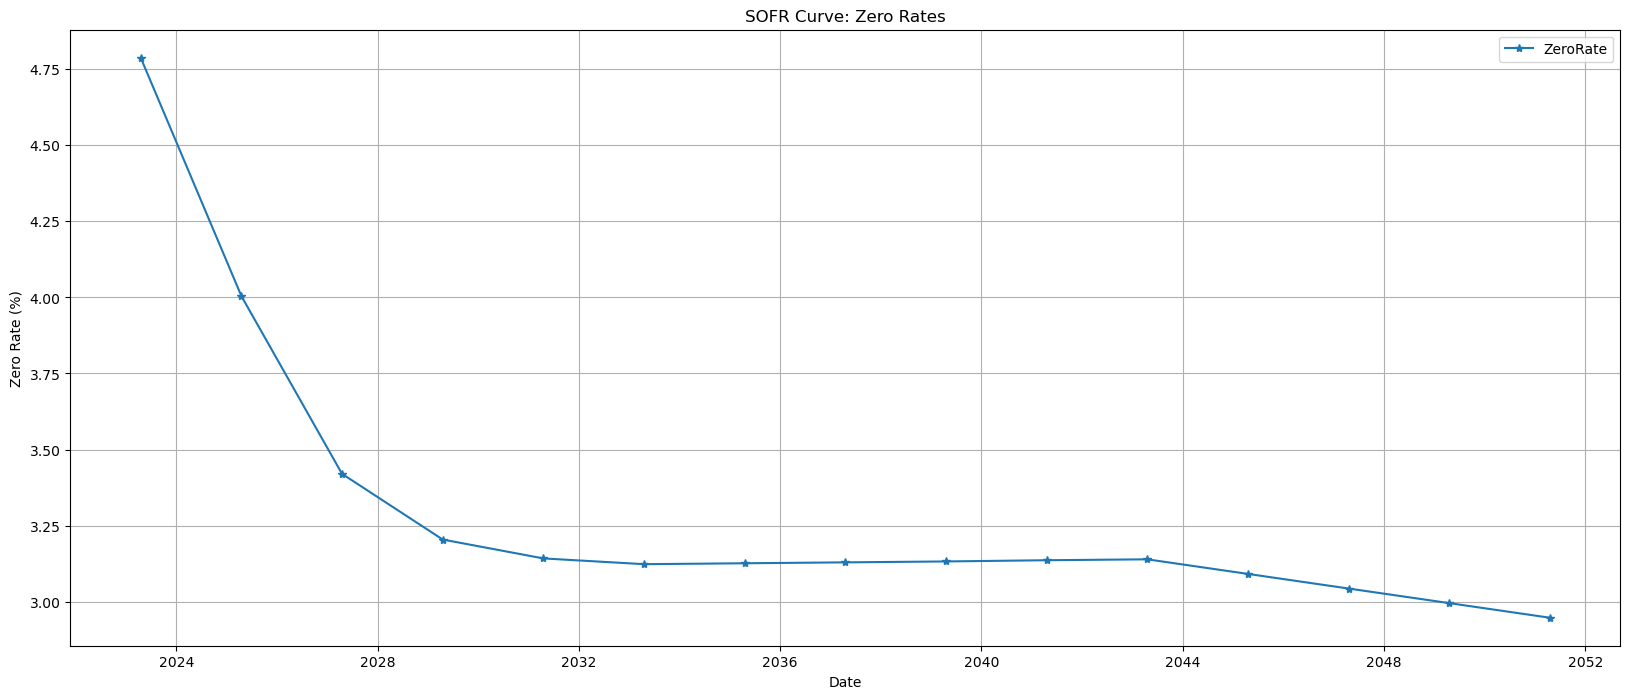

In [29]:
plot_SOFR_zero_rate(df_sofr_yield_curve_details)

In [30]:
def plot_SOFR_discount_factor(df_sofr_yield_curve_details):

    plt = df_sofr_yield_curve_details.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors', figsize=(20,8))
    plt.set_ylabel('Discount Factors')
    plt.set_xlabel('Date')

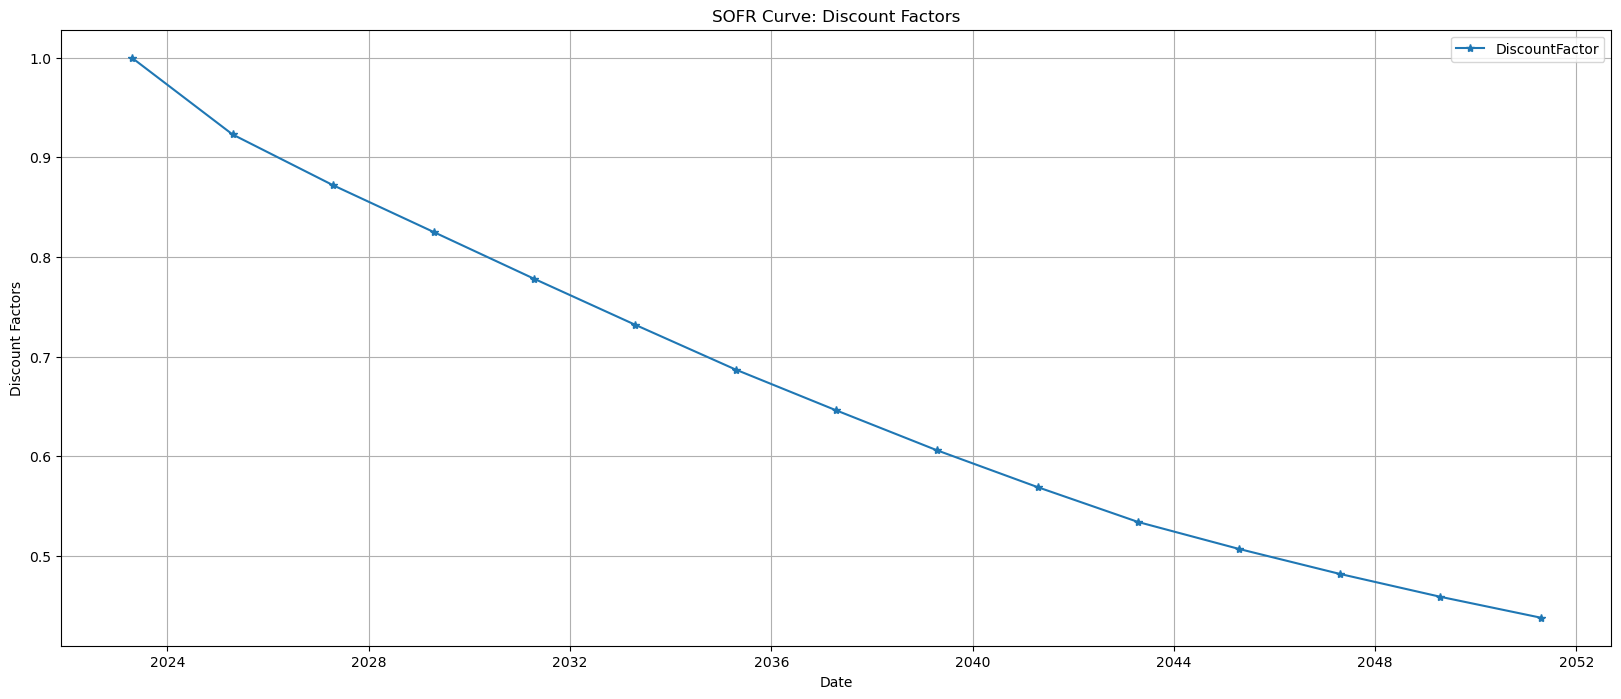

In [31]:
plot_SOFR_discount_factor(df_sofr_yield_curve_details)

# Problem 4: CDS Hazard Rate calibration and valuation
## Follow Section "12. CDS Hazard Rate calibration + Pricing" in the QuantLib Intro notebook !!!

## a. Load and explore the CDS market data (IBM credit issuer)

Load the `cds_market_data_eod` Excel file into a dataframe. 

Plot the historical time series of CDS Par Spreads for the available tenors.


In [32]:
df_cds_market = pd.read_excel('data/cds_market_data_eod.xlsx', sheet_name='Sheet1')
df_cds_market[['par_spread_1y','par_spread_2y','par_spread_3y','par_spread_5y','par_spread_7y','par_spread_10y']] \
    = df_cds_market[['par_spread_1y','par_spread_2y','par_spread_3y','par_spread_5y','par_spread_7y','par_spread_10y']].multiply(100)

In [33]:
import matplotlib.pyplot as plt

def plot_CDS_par_spread(df_cds_market):

    fig, ax = plt.subplots(figsize=(20, 8))
    ax.plot(df_cds_market['date'], df_cds_market['par_spread_1y'], label='1Y')
    ax.plot(df_cds_market['date'], df_cds_market['par_spread_2y'], label='2Y')
    ax.plot(df_cds_market['date'], df_cds_market['par_spread_3y'], label='3Y')
    ax.plot(df_cds_market['date'], df_cds_market['par_spread_5y'], label='5Y')
    ax.plot(df_cds_market['date'], df_cds_market['par_spread_7y'], label='7Y')
    ax.plot(df_cds_market['date'], df_cds_market['par_spread_10y'], label='10Y')

    ax.set_title('Historical Time Series of CDS Par Spreads for different Tenors')
    ax.set_xlabel('Date')
    ax.set_ylabel('CDS Par Spreads')

    ax.legend()
    plt.grid(True)

    plt.show();

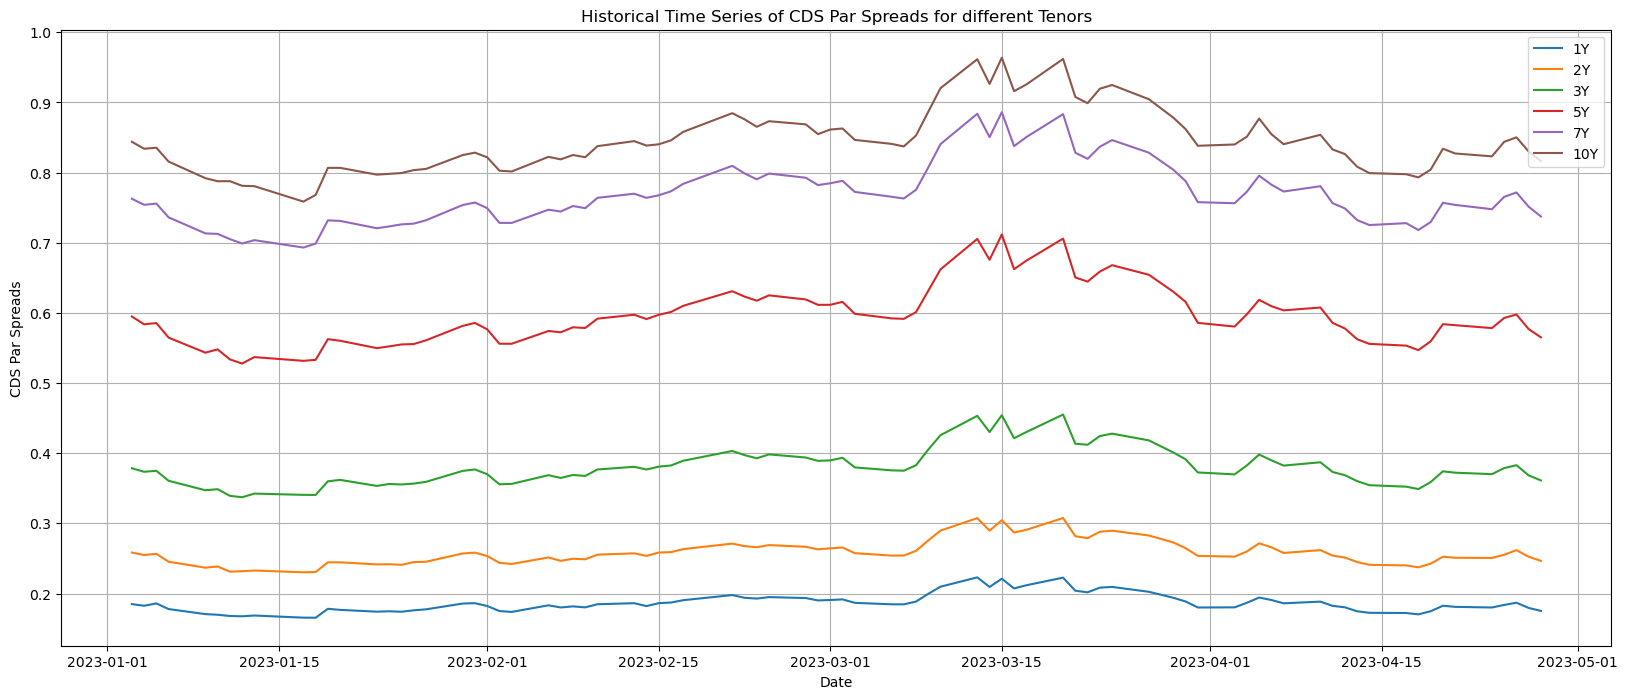

In [34]:
plot_CDS_par_spread(df_cds_market)

## b. Calibrate the IBM hazard rate curve as of 2023-04-28

Follow section 12a. Use the calibrated SOFR discount curve from 2b.

In [35]:
def calibrate_hazard_rate_curve(df_cds_market, sofr_yield_curve, date):

    sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)
    settle_days = 2

    df_cds_market_ = df_cds_market[df_cds_market['date'] == pd.to_datetime(date)].reset_index(drop=True)

    CDS_recovery_rate = df_cds_market_['cds_assumed_recovery'][0]

    CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
                
    CDS_spreads = [df_cds_market_['par_spread_1y'][0], df_cds_market_['par_spread_2y'][0], df_cds_market_['par_spread_3y'][0], \
        df_cds_market_['par_spread_5y'][0], df_cds_market_['par_spread_7y'][0], df_cds_market_['par_spread_10y'][0]]

    CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                    ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
                
    for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

    # bootstrap hazard_rate_curve
    hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
    hazard_rate_curve.enableExtrapolation()

    # Display calibrated hazard rates and survival probabilities
    hazard_list = [(hr[0].to_date(), hr[1] * 100, hazard_rate_curve.survivalProbability(hr[0])) for hr in hazard_rate_curve.nodes()]
    grid_dates, hazard_rates, surv_probs = zip(*hazard_list)

    df_hazard_rates = pd.DataFrame(data={'Date': grid_dates, 'HazardRate': hazard_rates,'SurvivalProb': surv_probs})

    return df_hazard_rates

In [36]:
df_hazard_rates = calibrate_hazard_rate_curve(df_cds_market, sofr_yield_curve, '2023-04-28')
df_hazard_rates

,Date,HazardRate,SurvivalProb
0,2023-04-14,0.002898,1.000000
1,2024-06-20,0.002898,0.999965
2,2025-06-20,0.005546,0.999909
3,2026-06-22,0.010360,0.999803
4,2028-06-20,0.015204,0.999496
5,2030-06-20,0.020474,0.999081
6,2033-06-20,0.017192,0.998558


## c. Plot the calibrated Hazard Rates and Survival Probability curves
Follow section 12b. Use the calibrated SOFR discount curve from 2b.

In [37]:
def plot_hazard_rates(df_hazard_rates):

    plt = df_hazard_rates.plot(x='Date', y='HazardRate', grid=True, style='*-', title='IBM Hazard Rates Curve', figsize=(20,8))
    plt.set_ylabel('Hazard Rate (%)')
    plt.set_xlabel('Date')

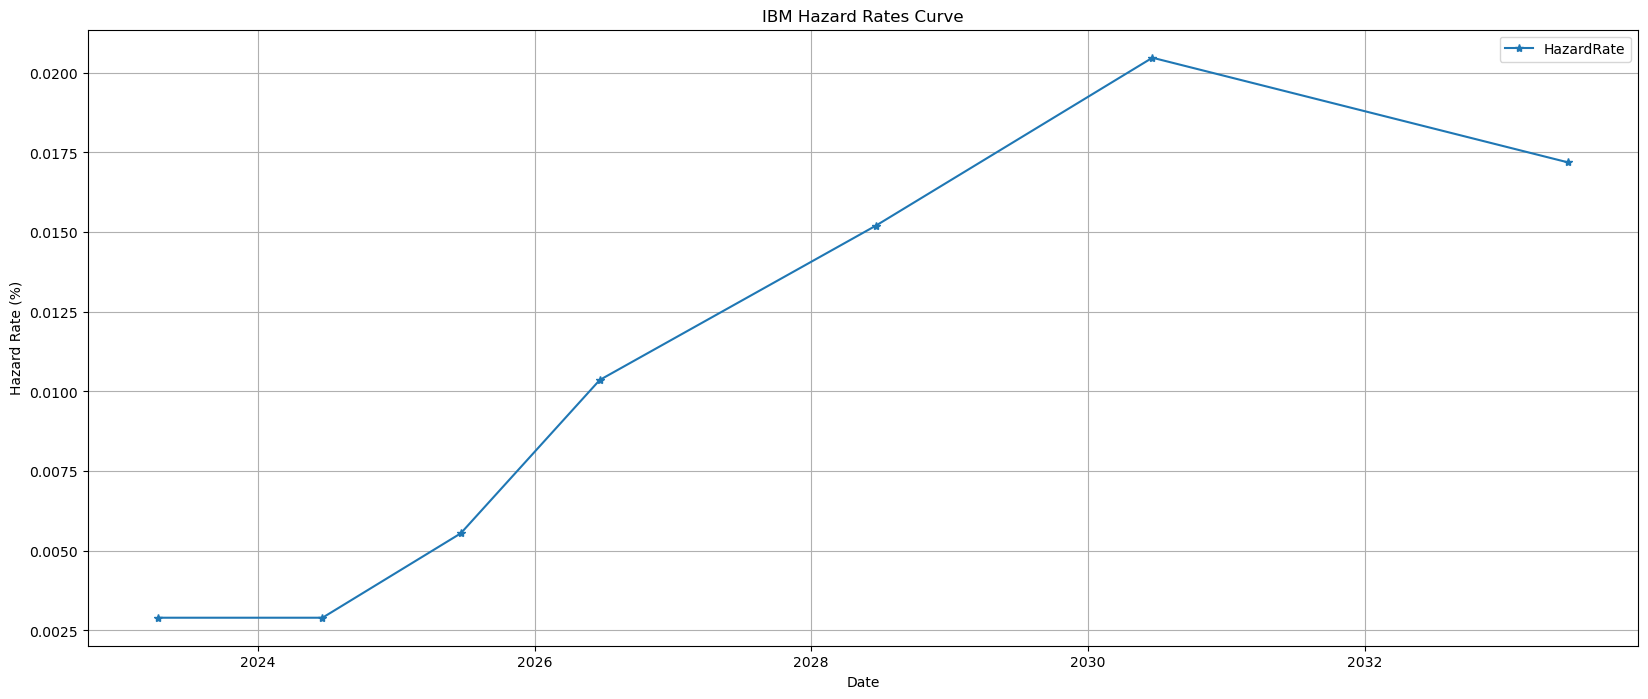

In [38]:
plot_hazard_rates(df_hazard_rates)

In [39]:
def plot_survival_probability(df_hazard_rates):

    plt = df_hazard_rates.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve', figsize=(20,8))
    plt.set_ylabel('Survival Probability')
    plt.set_xlabel('Date')

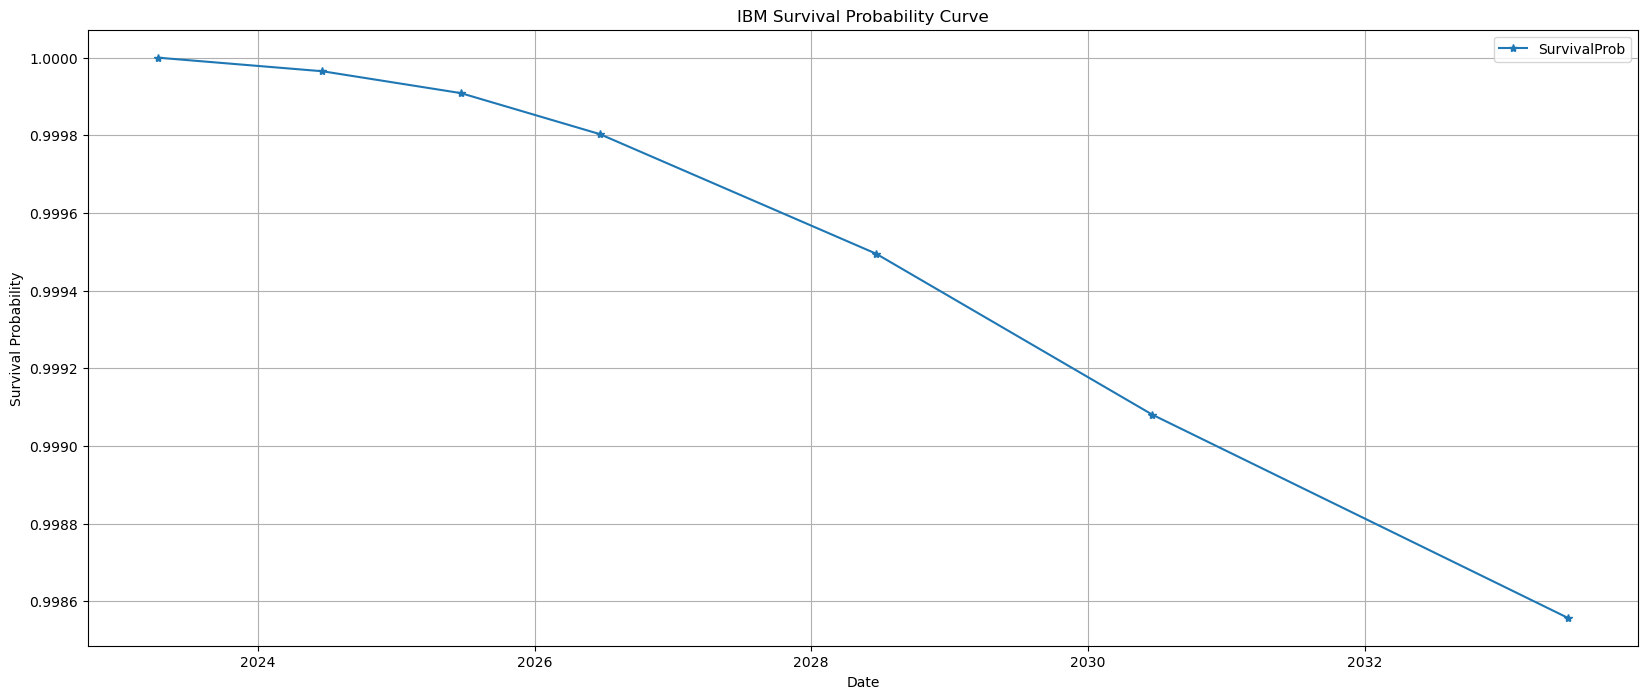

In [40]:
plot_survival_probability(df_hazard_rates)

## d. Compute the fair/par spread and PV of a CDS 

Follow section 12c. Construct a CDS object with 100 bps coupon and 2027-06-20 maturity. Compute the fair/par spread and PV.




In [45]:
def compute_cds_valuation_results(df_cds_market, sofr_yield_curve, date):

    sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)
    settle_days = 2

    df_cds_market_ = df_cds_market[df_cds_market['date'] == pd.to_datetime(date)].reset_index(drop=True)

    CDS_recovery_rate = df_cds_market_['cds_assumed_recovery'][0]

    CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
                
    CDS_spreads = [df_cds_market_['par_spread_1y'][0], df_cds_market_['par_spread_2y'][0], df_cds_market_['par_spread_3y'][0], \
        df_cds_market_['par_spread_5y'][0], df_cds_market_['par_spread_7y'][0], df_cds_market_['par_spread_10y'][0]]

    CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                    ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(),\
                                         CDS_recovery_rate, sofr_yield_curve_handle)
                
    for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

    # bootstrap hazard_rate_curve
    hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
    hazard_rate_curve.enableExtrapolation()

    # CDS specs
    side = ql.Protection.Seller

    face_notional = 100

    contractual_spread = 100 / 10000  # 100 bps coupon

    cds_start_date = ql.Date(28, 4, 2023)  
    cds_maturity_date = ql.Date(20, 6, 2027)  # 2027-06-20 maturity

    # Create CDS schedule
    cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                                ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

    # Create CDS object
    cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

    # Create CDS pricing engine
    default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
    cds_engine = ql.MidPointCdsEngine(default_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
    cds_obj.setPricingEngine(cds_engine)


    # Print CDS valuation results
    print('CDS protection start date:', cds_obj.protectionStartDate())
    print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
    print('CDS PV:', round(cds_obj.NPV(), 4))    
    print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
    print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
    print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))

In [46]:
compute_cds_valuation_results(df_cds_market, sofr_yield_curve, "2023-04-28")

CDS protection start date: April 28th, 2023
CDS fair/par spread: 0.489
CDS PV: 3.8523
CDS Premium Leg PV: 3.8713
CDS Default Leg PV -0.0189
Survival Prob. to Maturity: 0.9997
